In [13]:
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from keras.utils import img_to_array

from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from datetime import datetime

In [2]:
# 이미지 증강 객체 생성
gen = ImageDataGenerator(rotation_range=15, shear_range=0.1,
                         width_shift_range=0.3, rescale=1./255)

# 증강 이미지 적용 및 실행
data_path = './data/flower_photos/'
batch_size = 2313
data_gen = gen.flow_from_directory(directory=data_path, batch_size=batch_size,
                                   shuffle=True, target_size=(320, 320),
                                   class_mode='categorical')
img, label = data_gen.next()

Found 2313 images belonging to 5 classes.


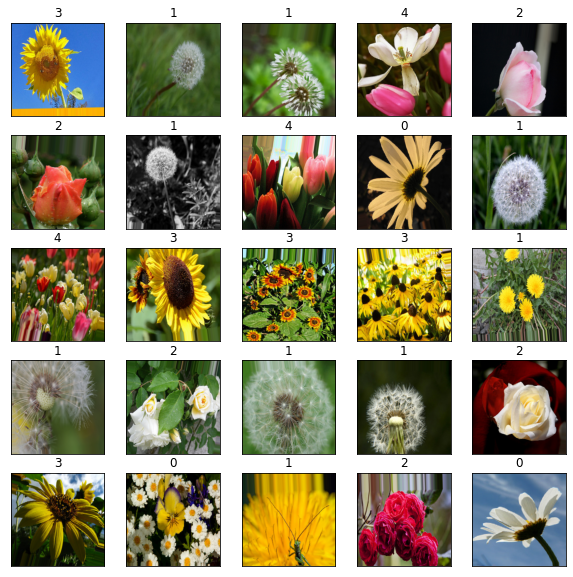

In [4]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(str(np.argmax(label[i])))
    plt.imshow(img[i])

In [5]:
result = []
for i in range(2313):
    result.append(np.argmax(label[i]))
result = np.array(result).reshape(-1, 1)

print(result.shape)

(2313, 1)

In [7]:
# train_data, test_data split
x_train, x_test, y_train, y_test = train_test_split(
    img, result, test_size=0.3, random_state=1004)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1619, 320, 320, 3)
(694, 320, 320, 3)
(1619, 1)
(694, 1)


In [8]:
# 신경망에 입력할 형태로 변환
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [9]:
# 보강할 학습데이터 이미지 생성
augment_ratio = 1.5
augment_size = int(augment_ratio * x_train.shape[0])

print(augment_size)

# 전체 x_train 갯수의 150% 비율 만큼
randidx = np.random.randint(x_train.shape[0], size=augment_size)

# 임의로 선택된 데이터는 원본 데이터를 참조하기 때문에 원본 데이터에 영향을 줄 수 있음
# copy() 함수로 안전하게 복사본 생성
x_augmented = x_train[randidx].copy()
y_augmented = y_train[randidx].copy()

print(x_augmented.shape, y_augmented.shape)

# 이미지 보강 실행
x_augmented, y_augmented = gen.flow(x_augmented, y_augmented,
                                    batch_size=augment_size, shuffle=False).next()

2428
(2428, 320, 320, 3) (2428, 1)


In [10]:
# x_train, y_train에 보강된 데이터(튜플로) 추가
x_train = np.concatenate((x_train, x_augmented))
y_train = np.concatenate((y_train, y_augmented))

print(x_train.shape, y_train.shape)

(4047, 320, 320, 3) (4047, 1)


In [12]:
cnn = Sequential()
cnn.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu',
               input_shape=(32, 32, 3)))
cnn.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
cnn.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
cnn.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(10, activation='softmax'))

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

In [ ]:
start_time = datetime.now()

cnn.compile(loss='sparse_categorical_crossentropy',
            optimizer=Adam(), metrics=['accuracy'])

# 손실함수를 10 epochs 마다 검사하여 더 이상 줄어들지 않으면 종료
# EarlyStopping(모니터링 값, 대기 epochs)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# 학습 중인 모델을 자동 저장
model_checkpoint = ModelCheckpoint(filepath='C:/python/machine/data/bast.h5',
                                   monitor='val_loss',
                                   save_base_only=True,
                                   verbose=1)

hist = cnn.fit(x_train, y_train, batch_size=256, epochs=250,
               validation_data=(x_test, y_test), callbacks=[early_stopping, model_checkpoint])

end_time = datetime.now()

print('경과시간 =', end_time - start_time)